# Simple baseline GDP

## Pre-requisite : declaring Fred API KEY

Following command will add `FRED_API_KEY` to your `zsh` environment, this has to be done at least once.

    echo 'export FRED_API_KEY=your_API_key_here' >> ~/.zshenv
    
Then make sure your restart your terminal/Jupyter notebook to make sure this change is effective.

You should now be able to print your key when executing the following

    echo $FRED_API_KEY

In [1]:
from fredapi import Fred

In [2]:
fred = Fred()

## Real Gross Domestic Product series overview

In [3]:
gdpc1 = fred.get_series('GDPC1')

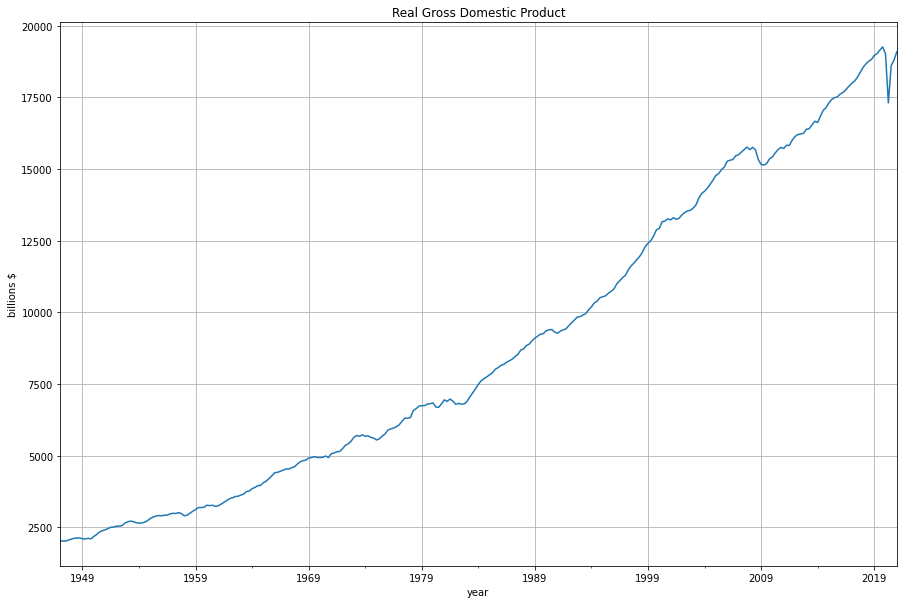

In [4]:
gdpc1.plot(
    title='Real Gross Domestic Product',
    figsize=(15, 10),
    xlabel='year',
    ylabel='billions $',
    grid=True,
);

## Statistical inference modelling using ARIMA

### Decomposing the series

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
decomposed_add = seasonal_decompose(gdpc1, model='additive')
decomposed_mul = seasonal_decompose(gdpc1, model='multiplicative')

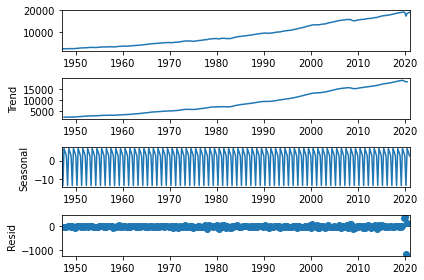

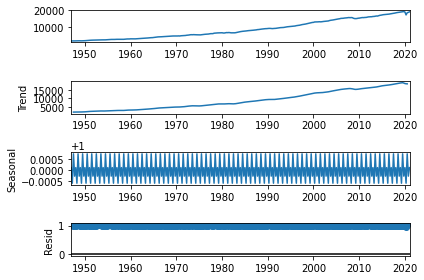

In [7]:
decomposed_add.plot();
decomposed_mul.plot();

In [8]:
import matplotlib.pyplot as plt

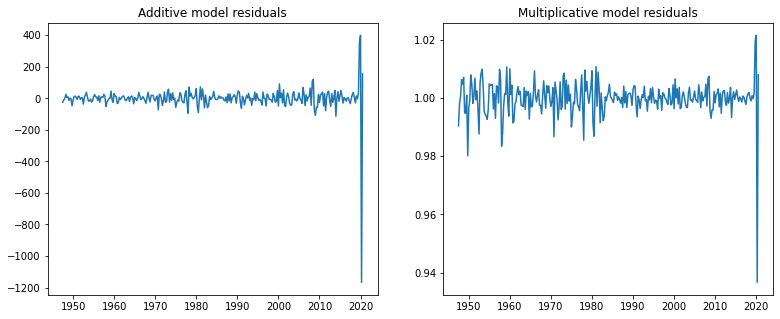

In [9]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
ax1.plot(decomposed_add.resid); ax1.set_title('Additive model residuals')
ax2.plot(decomposed_mul.resid); ax2.set_title('Multiplicative model residuals');

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
adfuller(decomposed_add.resid.dropna())[1], adfuller(decomposed_mul.resid.dropna())[1]

(1.4152833925977715e-13, 3.1018930786245876e-11)

**Additive decomposition** shows better ADfuller score, let's use this method.

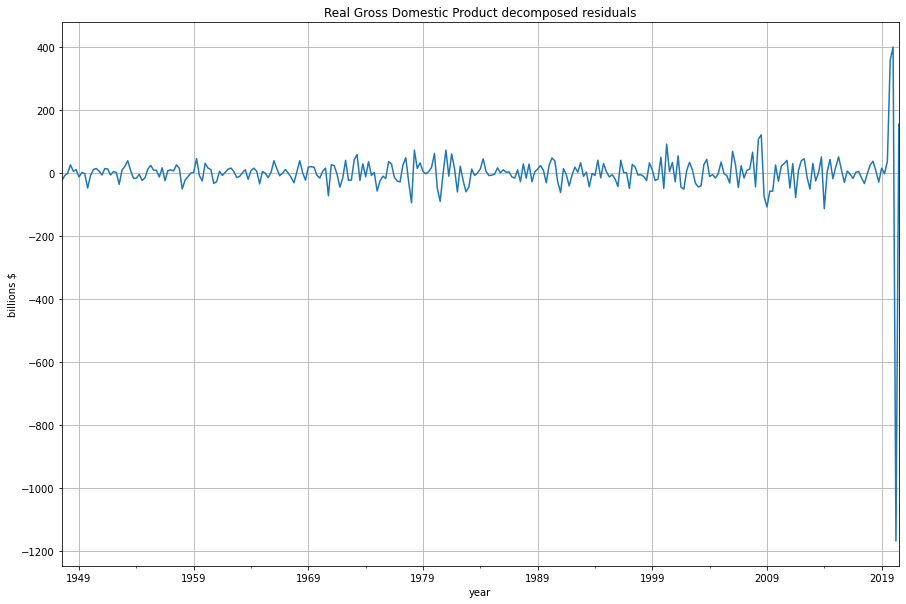

In [12]:
decomposed_resid = decomposed_add.resid.dropna()
decomposed_resid.plot(
    title='Real Gross Domestic Product decomposed residuals',
    figsize=(15, 10),
    xlabel='year',
    ylabel='billions $',
    grid=True,
);

### Differentiating

In [13]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [14]:
gdpc1_d1 = gdpc1.diff()[1:]
gdpc1_d2 = gdpc1_d1.diff()[1:]

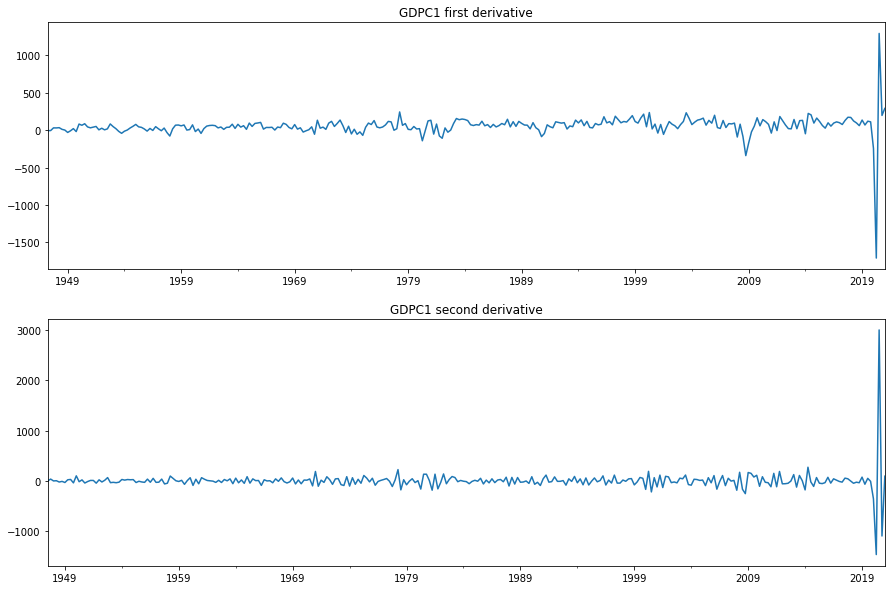

In [15]:
plt.subplots(2, 1, figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title('GDPC1 first derivative')
gdpc1_d1.plot()

plt.subplot(2, 1, 2)
plt.title('GDPC1 second derivative')
gdpc1_d2.plot()
plt.show()

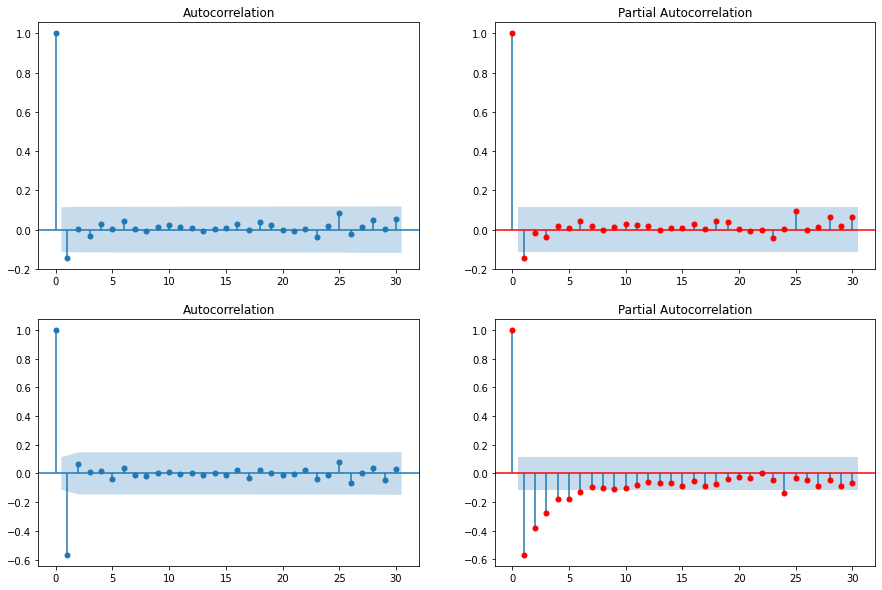

In [16]:
plt.subplots(2, 2, figsize=(15, 10))
plot_acf(gdpc1_d1, lags=30, ax=plt.subplot(2, 2, 1))
plot_pacf(gdpc1_d1, lags=30, ax=plt.subplot(2, 2, 2), color='r')
plot_acf(gdpc1_d2, lags=30, ax=plt.subplot(2, 2, 3))
plot_pacf(gdpc1_d2, lags=30, ax=plt.subplot(2, 2, 4), color='r')
plt.show()

In [17]:
print(
    f'diff d=1, adfuller p-value: {adfuller(gdpc1_d1)[1]}\n'
    f'diff d=2, adfuller p-value: {adfuller(gdpc1_d2)[1]}'
)

diff d=1, adfuller p-value: 0.0
diff d=2, adfuller p-value: 2.5450795477849187e-14


Based on those metrics, we can infer the following ARIMA coefficients:
 - `d=1`: a differentiation of order `1` is enough to stabilize the series,
 - `q=2`: according to ACF
 - `p=2`: according to PACF

## Modelling

### Train / test split

In [18]:
year_cut = 2018
gdpc1_train = gdpc1[gdpc1.index.year < year_cut]
gdpc1_test = gdpc1[gdpc1.index.year >= year_cut]
len(gdpc1_train), len(gdpc1_test)

(284, 13)

### ARIMA modelling

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
p=2
d=1
q=2
model = ARIMA(gdpc1_train, (p, d, q)).fit()
model.summary()

/Users/laurent/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/laurent/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  283
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1566.574
Method:                       css-mle   S.D. of innovations             61.325
Date:                Tue, 29 Jun 2021   AIC                           3145.147
Time:                        08:24:38   BIC                           3167.020
Sample:                    04-01-1947   HQIC                          3153.917
                         - 10-01-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.9211      7.825      7.402      0.000      42.583      73.259
ar.L1.D.y      0.6049      0.786      0.770      0.441      -0.935       2.145
ar.L2.D.y      0.0298      0.605      0.049      0.961      -1.156       1.215
ma.L1.D.y     -0.2832      0.784     -0.361      0.718      -1.820       1.254
ma.L2.D.y      0.0719      0.360      0.200      0.842      -0.634       0.778
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5368           +0.0000j            1.5368            0.0000
AR.2          -21.8396           +0.0000j           21.8396            0.5000
MA.1            1.9686           -3.1662j            3.7283           -0.1615
MA.2            1.9686           +3.1662j            3.7283            0.1615
-----------------------------------------------------------------------------
"""

Our p-values are quite high, meaning our trust in that baseline model is pretty limited.

### Forecast

In [21]:
import pandas as pd
import numpy as np

In [22]:
forecast, stderr, conf = model.forecast(len(gdpc1_test))

In [27]:
gdpc1_forecast = pd.DataFrame(
    {
        'truth': gdpc1[gdpc1_test.index],
        'forecast': forecast,
        'err': gdpc1[gdpc1_test.index] - forecast,
        'stderr': stderr,
        'conf_inf': conf[:,0],
        'conf_sup': conf[:,1],
    },
    index=gdpc1_test.index,
)
gdpc1_forecast

,truth,forecast,err,stderr,conf_inf,conf_sup
2018-01-01,18530.483,18468.986641,61.496359,61.324692,18348.792454,18589.180829
2018-04-01,18654.383,18567.894710,86.488290,101.635551,18368.692690,18767.096730
2018-07-01,18752.355,18652.147140,100.207860,142.036787,18373.760153,18930.534128
2018-10-01,18813.923,18727.217186,86.705814,180.141416,18374.146499,19080.287872
2019-01-01,18950.347,18796.296167,154.050833,215.537505,18373.850419,19218.741915
2019-04-01,19020.599,18861.477579,159.121421,248.290095,18374.837935,19348.117223
2019-07-01,19141.744,18924.122859,217.621141,278.634489,18378.009296,19470.236422
2019-10-01,19253.959,18985.117911,268.841089,306.849095,18383.704735,19586.531087
2020-01-01,19010.848,19045.039180,-34.191180,333.204216,18391.970917,19698.107443
2020-04-01,17302.511,19104.261752,-1801.750752,357.942882,18402.706594,19805.816910


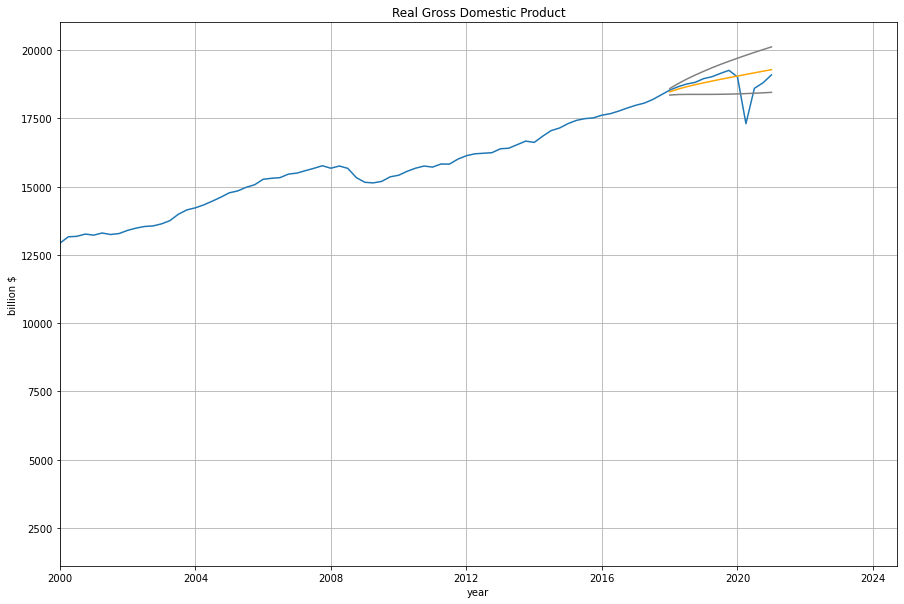

In [25]:
plt.subplots(1, 1, figsize=(15, 10))
plt.title('Real Gross Domestic Product')
plt.plot(gdpc1, label='truth')
plt.plot(gdpc1_forecast.forecast, color='orange')
plt.plot(gdpc1_forecast.conf_inf, color='gray')
plt.plot(gdpc1_forecast.conf_sup, color='gray');
plt.xlabel('year')
plt.ylabel('billion $')
plt.grid()
plt.xlim(left=np.datetime64('2000', 'ns'));